<a href="https://colab.research.google.com/github/EAkeweje/GEOMETRIC-LEARNING-FOR-FLOWS-IN-POROUS-SYSTEMS/blob/main/Nadaraya-Watson%20Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Ignore this cell. 
#for access to data files
%cd /content/drive/MyDrive/Skoltech/Research/GDL

/content/drive/MyDrive/Skoltech/Research/GDL


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import PIL
import pandas as pd
from statsmodels.nonparametric.kernel_regression import KernelReg
from tqdm.notebook import tqdm
import json
import time
import cv2
import random
from joblib import Parallel, delayed
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#####custom functions########
import os
import sys
sys.path.append(os.getcwd()+'/scripts')

from utils import *
from NWR import *

#Experiments 1: Checking the inflence of considering graph structure.

Text(-10, 0.8, 'Triangle Density Kernel \n with $bandwidth = 10$')

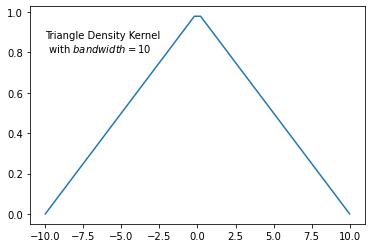

In [8]:
data_points = np.linspace(-10,10)
bw=10
plt.plot(data_points,triangle_density(data_points,bw))
plt.text(-10,0.8,f'Triangle Density Kernel \n with $bandwidth = {bw}$')

In [9]:
'''
Change directory to any pore image. The function, gen_pore_array, converts the pore image to pore array.
If you choose to use a pore array then use
pore_array = 'path_to_pore array'
'''
pore_array = gen_pore_array("./Dataset/Fluid Flow Simulation/1.png")

## Data Processing
- Extracting graph from pore image
- loading and coarseing the velocity data

In [10]:
#choose kernel size for coarse-graining
ks = 2

#use coarse graining with (2,2) kernel then contrust pore network
CG_G,n,e,c = pix_to_graph(coarse_grain(pore_array,kernel_size=ks),kernel_size=ks);
print(f'The generated pore network has {n} nodes')

#loading and coarse-graining fluid velocity field
f = np.loadtxt('./Dataset/Fluid Flow Simulation/vel_fields\\0_vel_array.dat')
f = np.reshape(f,(256,256,2))
f = np.rot90(f)
#coarse graining with a 2*2 kernel
# ks = 2 #kernel size
CG_f_0 = coarse_grain(f[:,:,0],ks)/(ks*ks)
CG_f_1 = coarse_grain(f[:,:,1],ks)/(ks*ks)

#creating X and Y
x = np.array([[i[0] for i in list(node_pos(CG_G).values())],[i[1] for i in list(node_pos(CG_G).values())]])
y = np.array([[CG_f_0[i] for i in list(node_pos(CG_G).values())], [CG_f_1[i] for i in list(node_pos(CG_G).values())]])

The generated pore network has 10696 nodes


In [11]:
num_points = x.shape[1]
np.random.seed(42)
num_sensors = 50
test_points = 535#num_points - num_sensors
test_loc = np.random.choice(range(num_points), test_points,replace=False)
x_test = []; y_test = []
for loc in test_loc:
  x_test.append(tuple(x[:,loc]))
  y_test.append(tuple(y[:,loc]))
# x_test = np.array(x_test)

In [12]:
x_train = np.delete(x,list(test_loc),1)
y_train = np.delete(y,list(test_loc),1)
x_test = np.array(x_test).T
y_test = np.array(y_test).T

In [13]:
y_train.shape

(2, 10161)

## Disregarding Graph Structure
Optimal bandwidth with CV

In [14]:
#LOOCV
x_train = x_train.astype('float')
x_test = x_test.astype('float')
CV_error = {}
r2 = {}
for h in tqdm(range(1,10)):
  y0_pred, y1_pred = LOOCV_NW_Reg(h,x_train,y_train[0],y_train[1])
  y_pred = np.vstack([y0_pred,y1_pred])
  error = np.linalg.norm(y_train - y_pred)/np.linalg.norm(y_train)
  CV_error[h] = error
  r2[h] = r2_score(y_train.T,y_pred.T)
print(CV_error)

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
#write to drive
loss = open(f'./LOOCV_error_NG_NWR_{test_points}.json', "w")
er = {'NSE':CV_error, 'r2':r2}
json.dump(er, loss)
loss.close()

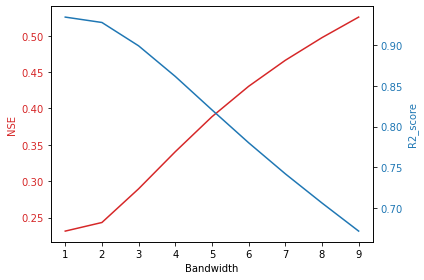

In [ ]:
#load losses and visualize
loss = json.load(open(f'./LOOCV_error_NG_NWR_{test_points}.json', "r"))
loss_CV = loss['NSE']
loss_r2 = loss['r2']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Bandwidth')
ax1.set_ylabel('NSE', color=color)
ax1.plot(list(loss_CV.keys()),list(loss_CV.values()), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2_score', color=color)  # we already handled the x-label with ax1
ax2.plot(list(loss_r2.keys()),list(loss_r2.values()), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# np.argmin()
h = np.argmin(list(loss_CV.values()))
print(h+1,loss_CV[f'{h+1}'])

1 0.231324868342823


Using optimum bandwidth, h=2

In [ ]:
x_train = x_train.astype('float')
x_test = x_test.astype('float')
h = 1
y0_pred, y1_pred = NW_Reg(h,x_train,y_train[0],y_train[1],x_test)
y_pred = np.vstack([y0_pred,y1_pred])
error = np.linalg.norm(y_test - y_pred)/np.linalg.norm(y_test)
print(f'Normalized Error: {error*100}%')
print('R2 score',r2_score(y_test.T,y_pred.T))

0it [00:00, ?it/s]

Normalized Error: 26.792932838700413%
R2 score 0.9139652712670945


In [ ]:
y_test.mean(axis=0).shape

(535,)

In [ ]:
##NFE
target = y_test - y_test.mean(axis=0)
pred = y_pred - y_test.mean(axis=0)
error = np.linalg.norm(target - pred)/np.linalg.norm(target)
print(f'Normalized Error: {error}')

Normalized Error: 0.3294941501049296


In [ ]:
y_test.shape

(2, 1070)

In [ ]:
pred_f_0 = np.zeros((128,128))
pred_f_1 = np.zeros((128,128))
pred_f_0[:,:]= np.nan; pred_f_1[:,:] = np.nan
orig_f_0 = np.zeros((128,128))
orig_f_1 = np.zeros((128,128))
orig_f_0[:,:]= np.nan; orig_f_1[:,:] = np.nan
g_f_0 = np.zeros((128,128))
g_f_1 = np.zeros((128,128))
g_f_0[:,:]= np.nan; g_f_1[:,:] = np.nan

x_train = x_train.astype('int')
x_test = x_test.astype('int')

for i,j in enumerate(x_train.T):
  ind = (j[0],j[1])
  pred_f_0[ind] = y_train[0,i]
  pred_f_1[ind] = y_train[1,i]
  orig_f_0[ind] = y_train[0,i]
  orig_f_1[ind] = y_train[1,i]
  g_f_0[ind] = 0.
  g_f_1[ind] = 0.

for i,j in enumerate(x_test.T):
  ind = (j[0],j[1])
  g_f_0[ind] = np.abs(y0_pred[i] - y_test[0,i])
  g_f_1[ind] = np.abs(y1_pred[i] - y_test[1,i])
  pred_f_0[ind] = y0_pred[i]
  pred_f_1[ind] = y1_pred[i]
  orig_f_0[ind] = y_test[0,i]
  orig_f_1[ind] = y_test[1,i]

Visualization of results :)


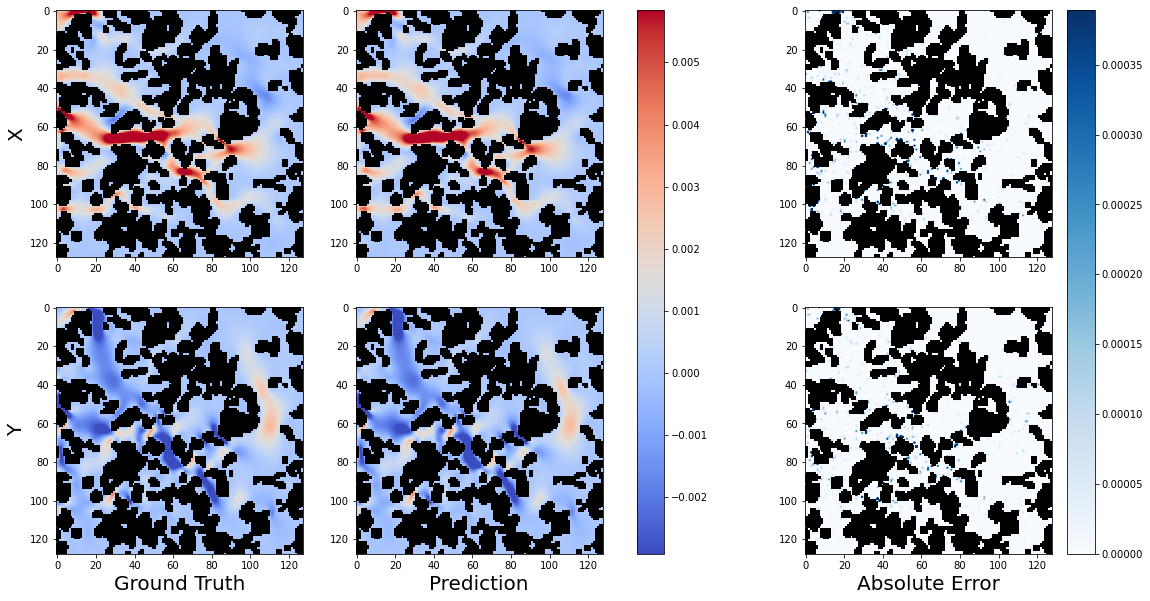

In [ ]:
#visualization
print('Visualization of results :)')
fig, ax = plt.subplots(2,3,figsize = (19,10))
#my porousing secret :(
for i in range(3):
    ax[0,i].set_facecolor((0., 0., 0.))
    ax[1,i].set_facecolor((0., 0., 0.))
ax[0,0].set_ylabel('X', fontsize = 20)
ax[1,0].set_ylabel('Y', fontsize = 20)

a = np.nanmin(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/5;
b = np.nanmax(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/3;
ax[0,0].imshow(orig_f_0, cmap='coolwarm',vmin = a, vmax =b);
ax[1,0].imshow(orig_f_1, cmap='coolwarm',vmin = a, vmax =b);
ax[0,1].imshow(pred_f_0, cmap='coolwarm',vmin = a, vmax =b);
im = ax[1,1].imshow(pred_f_1, cmap='coolwarm',vmin = a, vmax =b);

a = 0#np.nanmin(np.vstack([g_f_0,g_f_1]))/3; 
b = np.nanmax(np.vstack([g_f_0,g_f_1]))/20
ax[0,2].imshow(g_f_0, cmap='Blues',vmin = a, vmax =b);
im1 = ax[1,2].imshow(g_f_1, cmap='Blues', vmin = a, vmax = b);

# ax[0,0].set_title(f'Model Trained with {len(guage_space)} sensors',fontsize = 35)
ax[1,0].set_xlabel('Ground Truth', fontsize=20)
ax[1,2].set_xlabel('Absolute Error', fontsize=20)
ax[1,1].set_xlabel('Prediction', fontsize=20)
# plt.colorbar(im,ax = ax.ravel().tolist())
plt.colorbar(im,ax = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]])
plt.colorbar(im1,ax = [ax[0,2],ax[1,2]])
plt.savefig('NG_bandwitdh 10000.pdf')

## Using the Graph Structure

Again we utilize the triangle kernel only that now the shortest path length is used. Thus, the kernel is written as
$$\vec{v}(x) = \sum \frac{\mathcal{K}(\delta(x,x_i)) * \vec{v}(x_i)}{\sum \mathcal{K}(\delta(x,x_i))} $$ where $\delta(x,x_i$ is the shortest path distance between node $x$ and $x_i$.

As with the approximations with no structure consideration, we start again with cross validation to find the optimum bandwidth.

In [16]:
#get train and test nodes
test_nodes = []; train_nodes = []

for t_ in x_test.T:
  test_nodes += [x for x,y in CG_G.nodes(data=True) if y['pos']== tuple(t_)]
for t_ in x_train.T:
  train_nodes += [x for x,y in CG_G.nodes(data=True) if y['pos']== tuple(t_)]

In [17]:
len(train_nodes)

10161

In [ ]:
#LOOCV
def pred(source,h):
  #Nadaraya Algorithm with LOOCV
  predx, predy = Graph_Node_NW_Reg(source=source, target=train_nodes, h=h, G=CG_G, f= [CG_f_0, CG_f_1], LOOCV = True)
  return predx, predy

#get actual velocities
y_orig = []
for source in train_nodes:
  pos = CG_G.nodes[source]['pos']
  y_orig.append([CG_f_0[pos],CG_f_1[pos]])
    
errors = {}
r2 = {}
for h in tqdm(range(1,5)):
    predxy = Parallel(n_jobs = -1, verbose=0)(delayed(pred)(source, h) for source in train_nodes)
    error = np.linalg.norm(np.array(predxy) - np.array(y_orig))/np.linalg.norm(np.array(y_orig))
    errors[h] = error
    r2[h] = r2_score(y_orig, np.array(predxy))
print(f'Complete! \n {errors}')

  0%|          | 0/4 [00:00<?, ?it/s]

Complete! 
 {1: 0.23132895209217963, 2: 0.24567230183820168, 3: 0.2689682053252284, 4: 0.3055032709217367}


In [ ]:
#write to drive
loss = open(f'./LOOCV_error_G_NWR_{test_points}.json', "w")
er = {'NSE':errors, 'r2':r2}
json.dump(er, loss)
loss.close()

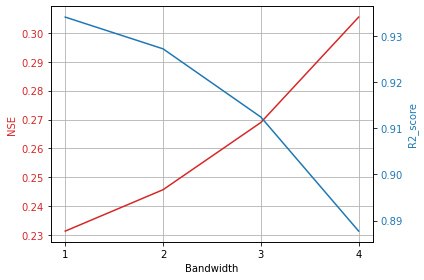

In [ ]:
loss = json.load(open(f'./LOOCV_error_G_NWR_{test_points}.json', "r"))
loss_CV = loss['NSE']
loss_r2 = loss['r2']

fig, ax1 = plt.subplots()
plt.grid()
color = 'tab:red'
ax1.set_xlabel('Bandwidth')
ax1.set_ylabel('NSE', color=color)
ax1.plot(list(loss_CV.keys()),list(loss_CV.values()), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R2_score', color=color)  # we already handled the x-label with ax1
ax2.plot(list(loss_r2.keys()),list(loss_r2.values()), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

plt.show()

In [ ]:
h = np.argmin(list(loss_CV.values()))
loss_CV[f'{h+1}']

0.2359095855479387

In [ ]:
#LOOCV
# dist_dict = dict(nx.shortest_path_length(CG_G))
start_time = time.time()
def pred(source):
  #Nadaraya Algorithm
  predx, predy = Graph_Node_NW_Reg(source=source, target=train_nodes, h=1, G=CG_G, f= [CG_f_0, CG_f_1], LOOCV = False) #dist_=dist_dict, 
  return predx, predy

predxy = Parallel(n_jobs = -1, verbose=0)(delayed(pred)(source) for source in test_nodes)

error = np.linalg.norm(np.array(predxy).T - y_test)/np.linalg.norm(np.array(y_test))
print(f'NSE error is {error}')
print(f'Time taken = {time.time() - start_time}')

NSE error is 0.26788477945968725
Time taken = 4.527607440948486


In [ ]:
print('R2 score',r2_score(y_test.T, np.array(predxy)))

R2 score 0.9139773182004673


In [ ]:
np.array(predxy).T.shape

(2, 535)

In [ ]:
##NFE
target = y_test - y_test.mean(axis=0)
pred = np.array(predxy).T - y_test.mean(axis=0)
error = np.linalg.norm(target - pred)/np.linalg.norm(target)
print(f'Normalized Error: {error}')

Normalized Error: 0.3294393647256561


In [ ]:
pred_f_0 = np.zeros((128,128))
pred_f_1 = np.zeros((128,128))
pred_f_0[:,:]= np.nan; pred_f_1[:,:] = np.nan
orig_f_0 = np.zeros((128,128))
orig_f_1 = np.zeros((128,128))
orig_f_0[:,:]= np.nan; orig_f_1[:,:] = np.nan
g_f_0 = np.zeros((128,128))
g_f_1 = np.zeros((128,128))
g_f_0[:,:]= np.nan; g_f_1[:,:] = np.nan

x_train = x_train.astype('int')
x_test = x_test.astype('int')
y_pred = np.array(predxy).T

for i,j in enumerate(x_train.T):
  ind = (j[0],j[1])
  pred_f_0[ind] = y_train[0,i]
  pred_f_1[ind] = y_train[1,i]
  orig_f_0[ind] = y_train[0,i]
  orig_f_1[ind] = y_train[1,i]
  g_f_0[ind] = 0.
  g_f_1[ind] = 0.

for i,j in enumerate(x_test.T):
  ind = (j[0],j[1])
  g_f_0[ind] = np.abs(y0_pred[i] - y_test[0,i])
  g_f_1[ind] = np.abs(y1_pred[i] - y_test[1,i])
  pred_f_0[ind] = y0_pred[i]
  pred_f_1[ind] = y1_pred[i]
  orig_f_0[ind] = y_test[0,i]
  orig_f_1[ind] = y_test[1,i]

Visualization of results :)


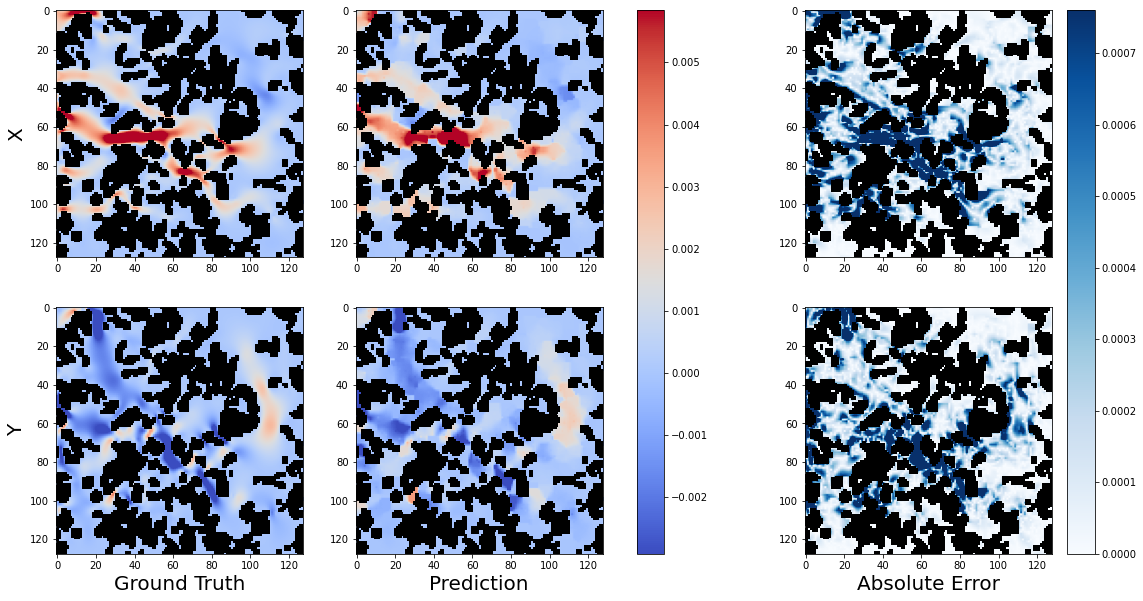

In [ ]:
#visualization
print('Visualization of results :)')
fig, ax = plt.subplots(2,3,figsize = (19,10))
#my porousing secret :(
for i in range(3):
    ax[0,i].set_facecolor((0., 0., 0.))
    ax[1,i].set_facecolor((0., 0., 0.))
ax[0,0].set_ylabel('X', fontsize = 20)
ax[1,0].set_ylabel('Y', fontsize = 20)

a = np.nanmin(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/5;
b = np.nanmax(np.vstack([np.vstack([pred_f_0,pred_f_1]),np.vstack([orig_f_0,orig_f_1])]))/3;
ax[0,0].imshow(orig_f_0, cmap='coolwarm',vmin = a, vmax =b);
ax[1,0].imshow(orig_f_1, cmap='coolwarm',vmin = a, vmax =b);
ax[0,1].imshow(pred_f_0, cmap='coolwarm',vmin = a, vmax =b);
im = ax[1,1].imshow(pred_f_1, cmap='coolwarm',vmin = a, vmax =b);

a = 0#np.nanmin(np.vstack([g_f_0,g_f_1]))/3; 
b = np.nanmax(np.vstack([g_f_0,g_f_1]))/20
ax[0,2].imshow(g_f_0, cmap='Blues',vmin = a, vmax =b);
im1 = ax[1,2].imshow(g_f_1, cmap='Blues', vmin = a, vmax = b);

# ax[0,0].set_title(f'Model Trained with {len(guage_space)} sensors',fontsize = 35)
ax[1,0].set_xlabel('Ground Truth', fontsize=20)
ax[1,2].set_xlabel('Absolute Error', fontsize=20)
ax[1,1].set_xlabel('Prediction', fontsize=20)
# plt.colorbar(im,ax = ax.ravel().tolist())
plt.colorbar(im,ax = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]])
plt.colorbar(im1,ax = [ax[0,2],ax[1,2]])
plt.savefig('G_bandwidth 10000.pdf')